# Deep Learning Tutorial

Deep Learning Tutorial based on https://spandan-madan.github.io/DeepLearningProject/.

Credits: [Spandan Madan](http://people.csail.mit.edu/smadan/web/).

## Imports

* In this section we import required packages.
* We can install these packages using the notebook itself.

In [1]:
# Inline figures
%matplotlib inline

In [2]:
# Installing Python packages from the notebook
import sys
#!conda install -c conda-forge --yes --prefix {sys.prefix} urllib2 # did not work cause of Python 2
# Change to python 3 by using urllib instead
#!{sys.executable} -m pip install urllib2 # did not work cause of Python 2
#!conda install -c conda-forge --yes --prefix {sys.prefix} wget # did not work
#!{sys.executable} -m pip install wget # worked
#!{sys.executable} -m pip install imdb # did not work
#!{sys.executable} -m pip install IMDbPY # worked

Based on [Jake Van Der Plas](http://jakevdp.github.io) blog post on [Installing Python packages on a Jupyter Notebook](http://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/).

In [3]:
# Web access packages
import urllib
import requests
import wget

# Utilities packages
import itertools
import time
import os
import json
import logging

# Movies database API packages
import imdb 
import tmdbsimple as tmdb


import numpy as np
import random as rd

# Figure and style packages
import matplotlib.pyplot as plt
import seaborn as sns

# Object serialization package
import pickle

# Custom utility functions 
from dltutorial.utils import get_movie_id_tmdb
from dltutorial.utils import get_movie_info_tmdb
from dltutorial.utils import get_movie_genres_tmdb
from dltutorial.utils import get_api_key_tmdb
from dltutorial.utils import get_movie_poster_tmdb

from dltutorial.utils import get_movie_info_imdb
from dltutorial.utils import get_movie_genres_imdb

## Style

In [4]:
plt.style.use('seaborn-darkgrid')
sns.set(rc={'figure.figsize':(9, 6)})

## Logging

* Here we instanciate a logging object to record our logs.

In [5]:
logging.basicConfig(filename="./dltutorial/logs/dev_logs.txt",
                    level=logging.INFO,
                    format=' %(asctime)s - %(funcName)s -'
                    '%(levelname)s - %(message)s')

## Utility functions

* You may want to create a private Python module containing only an ``__init__.py`` file that consists in a string variable ``API_KEY`` that is your private API key from [TMDB](https://www.themoviedb.org/). Else you can instanciate the ``api_key`` directly in your notebook but do not share it!

* Custom utility functions have been implemented in ``dltutorial.utils``.

* We create a folder where we store the scrapped movie posters.

In [6]:
logging.info('Setting posters storage folder...')

# Create a posters folder inside data folder
posters_path = './dltutorial/data/posters/'

        
if not os.path.exists(posters_path):
    logging.debug('%s does not exists. Creating relevant folders...' %
                 posters_path)
    # Recursive folder creation
    os.makedirs(posters_path)
else:
    logging.debug('%s already exists...' % posters_path)
    print('%s already exists...' % posters_path)

./dltutorial/data/posters/ already exists...


## Some examples

### TMDB

In [7]:
logging.info('Setting TMDB API key...')
if 'private' in os.listdir('./dltutorial'): #
    logging.debug('Private folder exists...')
    from dltutorial import private
    api_key = private.API_KEY
else:
    logging.debug('No private folder found...')
    print('There is no private folder.'
          'API key will remain blank if you do not set it.')
    api_key = '' # put your own API key but do not share it
# Set the TMDB API key
tmdb.API_KEY = api_key 
logging.debug('TMDB API key is set to %s...' % api_key)

# Instanciate a search object from TMDB
search_tmdb = tmdb.Search()

# Some examples
movie_name = "The Matrix"

movie_id = get_movie_id_tmdb(movie_name=movie_name, search_tmdb=search_tmdb)
print("%s has id %s\n" % (movie_name, movie_id))
movie_info = get_movie_info_tmdb(movie_name=movie_name, search_tmdb=search_tmdb)
print("%s has these info categories:\n %s\n" % (movie_name, movie_info.keys()))
movie_genres = get_movie_genres_tmdb(movie_name=movie_name, search_tmdb=search_tmdb)
print("%s belongs to these genres:\n %s\n" % (movie_name, movie_genres))

The Matrix has id 603

The Matrix has these info categories:
 dict_keys(['runtime', 'original_title', 'backdrop_path', 'spoken_languages', 'adult', 'original_language', 'vote_count', 'production_companies', 'video', 'belongs_to_collection', 'tagline', 'revenue', 'release_date', 'status', 'imdb_id', 'popularity', 'id', 'overview', 'vote_average', 'title', 'poster_path', 'genres', 'homepage', 'budget', 'production_countries'])

The Matrix belongs to these genres:
 [{'id': 28, 'name': 'Action'}, {'id': 878, 'name': 'Science Fiction'}]



### IMDB

In [8]:
movie_name = "The Matrix"
search_imdb = imdb.IMDb()

movie_genres = get_movie_genres_imdb(movie_name=movie_name, search_imdb=search_imdb)
print("%s movie belongs to genres:\n %s \n" % (movie_name, movie_genres))
movie_info = get_movie_info_imdb(movie_name=movie_name, search_imdb=search_imdb)
print("%s movie first 10 info categories:\n %s \n" % (movie_name, movie_info.keys()[:10]))

The Matrix movie belongs to genres:
 ['Action', 'Sci-Fi'] 

The Matrix movie first 10 info categories:
 ['cover url', 'casting department', 'synopsis', 'editorial department', 'transportation department', 'aspect ratio', 'original air date', 'production managers ', 'certificates', 'special effects companies'] 



## Multiple movies

#### Top 20 from TMDB

In [9]:
genres_dict_file = './dltutorial/data/genres_dict.pckl'

# Top 20 popular films
top_movies = tmdb.Movies().popular()['results']
# Create a TMDB genre object
genres = tmdb.Genres()
# Returns the genres list (ID/name)
genres_list = genres.movie_list()['genres']

# if genres dictionary does not exists
if not os.path.exists(genres_dict_file):
    # Create a genres dictionary
    genres_dict = dict()
    for genre in genres_list:
        genres_dict[genre['id']] = genre['name']
    logging.debug("Writing genres dict on hard disk...")
    with open(genres_dict_file, 'wb') as f:
        pickle.dump(genres_dict, f)
    logging.debug("Done saving genres dict in %s..." %
                 genres_dict_file)
# Else load existing one
else:
    logging.debug("Loading genres dict from hard disk...")
    with open(genres_dict_file, 'rb') as f:
        genres_dict = pickle.load(f)
    logging.debug("Done loading genres dict from %s..." %
                 genres_dict_file)


# Print the genres of top 5 movies
for movie in top_movies[:5]:
    genre_ids = movie['genre_ids']
    genre_names = list()
    for genre_id in genre_ids: 
        genre_names.append(genres_dict[genre_id])
    print("%s\n%s\n" % (movie['title'], genre_names))

Fifty Shades Freed
['Drama', 'Romance']

Zootopia
['Animation', 'Adventure', 'Family', 'Comedy']

Coco
['Adventure', 'Comedy', 'Family', 'Animation']

Star Wars: The Last Jedi
['Fantasy', 'Adventure', 'Science Fiction']

Black Panther
['Action', 'Adventure', 'Fantasy', 'Science Fiction']



#### Top 1000 movies from TMDB

In [10]:
movie_list_file = './dltutorial/data/tmdb_movie_list.pckl'

if not os.path.exists(movie_list_file):
    # Instantiate TMDB movies object
    all_movies = tmdb.Movies()
    # Instantiate empty list of movies to populate
    top1000_movies = list()
    # Number of pages to download
    n_pages = 50
    logging.debug("Downloading movie list from top %s pages..." % n_pages)
    for i in range(1, n_pages + 1):
        if i%10 == 0:
            msg = "%s out of %s movie pages downloaded (%s%%)..." % (i, n_pages, round(100 * i / n_pages, 1))
            print(msg)
            logging.debug(msg)
            time.sleep(5)
        current_page_movies = all_movies.popular(page=i)['results']
        top1000_movies.extend(current_page_movies)
    # Write binary in data folder in pickle format
    logging.debug("Writing %s movie results on disk..." % (len(top1000_movies)))
    with open(file=movie_list_file, mode='wb') as f:
        pickle.dump(top1000_movies, f)
    logging.debug("Done writing...")
else:
    # Open binary pickle file to load movie list variable
    logging.debug("Loading movies list from disk...")
    with open(file=movie_list_file, mode='rb') as f:
        top1000_movies = pickle.load(f)
    logging.debug("Done loading %s movies" % len(top1000_movies))

## Dealing with unbalanced dataset

Handling the multi-label component. Co-occurrence sheds some information that the dataset has imbalances.

* We want to investigate pairwise genres correlations.
    * First we build every possible pair from the movie genres available.

In [11]:
def list2pairs(input_list):
    """
    Generating all possible pairs of movies
    
    Parameters
    -----------
    - input_list: list
        generic list used to generate pairs
        
    Returns
    -----------
    - pairs: list
        list of pairs (tuples)
    """
    # Build all pairs of length 2 from input_list
    pairs = list(itertools.combinations(input_list, 2))
    # Add duplicate pairs
    pairs.extend([(elt, elt) for elt in input_list])
    return pairs

##### Debugging part: dropping missing genre

In [12]:
# Get all genre pairs from top 1000 movies
genre_pairs = list()
for movie in top1000_movies:
    genre_pairs.extend(list2pairs(movie['genre_ids']))
    
# We keep only unique pairs
unique_genres = np.unique(genre_pairs)
# We instantiate a correlation matrix
corr_matrix = np.zeros((len(unique_genres), len(unique_genres)))
for pair in genre_pairs:
    corr_matrix[np.argwhere(unique_genres == pair[0]), np.argwhere(unique_genres == pair[1])] += 1
    # If not duplicate pairs, affect symmetrical coefficient
    if pair[1] != pair[0]:
        corr_matrix[np.argwhere(unique_genres == pair[1]), np.argwhere(unique_genres == pair[0])] += 1
    
# Handling missing genres
#try:
#    assert len(genres_dict.keys()) == corr_matrix.shape[0]
#    assert len(genres_dict.keys()) == corr_matrix.shape[1]
#except:
#    print("Number of genres from TMDB %d" % len(genres_dict.keys()))
#    print("Correlation matrix shape: ", corr_matrix.shape)
#    missing_genres = [genre for genre in list(genres_dict.keys()) if genre not in unique_genres]
#    for genre in missing_genres:
#        print("Removing genre %s from genres dictionary..." % genres_dict[genre])
#        genres_dict.pop(genre, None)
#    assert len(genres_dict.keys()) == corr_matrix.shape[0]
#    assert len(genres_dict.keys()) == corr_matrix.shape[1]

#### Correlation matrix visualization

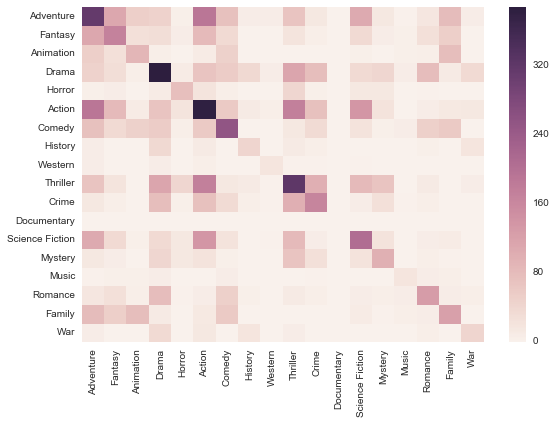

In [13]:
# Return genres names
annotations = [genres_dict[genre_id] for genre_id in unique_genres]
# Display correlation matrix
sns.heatmap(corr_matrix, xticklabels=annotations, yticklabels=annotations);

* Diagonal terms correspond to self-pairs, i.e. the number of times a genre co-occur. That is nothing else than the total times said genre occurred. *We observe that Drama seems to be the most common genre*.

* Additionally we notice that Action often occurs alongside Adventure, Thriller and Mystery.

### Biclustering

In [14]:
from sklearn.cluster import SpectralCoclustering

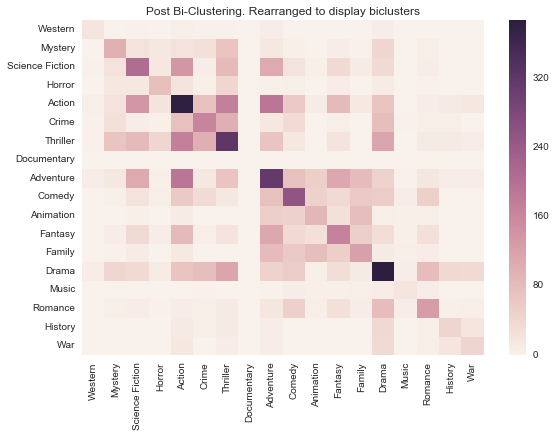

In [15]:
# Instantiate model
model = SpectralCoclustering(n_clusters=5, random_state=42)
# Fit model
model.fit(corr_matrix)

# Rearrange data based on bi-clusters
fit_data = corr_matrix[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

# Build rearranged annotations
sorted_annotations = [genres_dict[unique_genres[idx]] for idx in np.argsort(model.row_labels_)]

# Display biclustering aftermath
sns.heatmap(fit_data, xticklabels=sorted_annotations, yticklabels=sorted_annotations)
plt.title("Post Bi-Clustering. Rearranged to display biclusters");

* We see genres are clustered into groups. For instance: *Thriller, Action, Horror and Crime* belong to 1 cluster while *Adventure, Fantasy, Animation, Comedy and Family* belong to another.

## Scrapping TMDB movies

In [16]:
genre_movies_list_file = './dltutorial/data/tmdb_genre_movies_list.pckl'

if not os.path.exists(genre_movies_list_file):
    # Instantiate empty movies list
    genre_movies = list()
    # Set base year to prevent duplicates
    # We decrement the base_year for every genre,
    # increasing our chances to encounter duplicate movies
    base_year = 2017
    # Set number of pages to download per genre
    n_pages_per_genre = 5
    print("Start downloading...")
    logging.debug("Starting downloading movies from TMDB."
                 "Each genre will download %d movies..." %
                  (20 * n_pages_per_genre))
    for genre_id in unique_genres:
        logging.debug("Downloading movies from genre %s..." %
                     genres_dict[genre_id])
        print("Downloading movies from genre %s..." %
                     genres_dict[genre_id])
        # Decrement base_year. Described above
        base_year -= 1
        for page_id in range(1, n_pages_per_genre + 1):
            # Let TMDB server have some rest
            time.sleep(0.5)
            # Setting URL using parameters
            url = 'https://api.themoviedb.org/3/discover/movie?api_key=' + api_key
            url += '&language=en-US&sort_by=popularity.desc&year=' + str(base_year)
            url += '&with_genres=' + str(genre_id) + '&page=' + str(page_id)
            # Retrieve results
            data = urllib.request.urlopen(url).read().decode('utf8')
            # Append results to genre_movies
            genre_movies.extend(json.loads(data)["results"])
    print("Done downloading...")

    # Write binary in data folder in pickle format
    logging.debug("Writing %s movie results on disk..." % (len(genre_movies)))
    with open(file=genre_movies_list_file, mode='wb') as f:
        pickle.dump(genre_movies, f)
    logging.debug("Done writing...")
else:
    # Open binary pickle file to load movie list variable
    logging.debug("Loading movies list from disk...")
    with open(file=genre_movies_list_file, mode='rb') as f:
        genre_movies = pickle.load(f)
    logging.debug("Done loading %s movies..." % len(genre_movies))

#### Removing duplicates

In [17]:
# Instantiate empty id list
seen_ids = list()
# Instantiate empty movie list
unique_movies = list()
logging.debug("Originally we had %s movies..." % len(genre_movies))
print("Originally we had %s movies..." % len(genre_movies))
for movie in genre_movies:
    movie_id = movie['id']
    if movie_id in seen_ids:
        continue
    else:
        seen_ids.append(movie_id)
        unique_movies.append(movie)
# Assert if we rightfully removed duplicates
assert len(unique_movies) == len(np.unique([movie['id'] for movie in genre_movies]))
logging.debug("After removing duplicates we have %s movies..."
              % len(unique_movies))
print("Now we have %s movies..." % len(unique_movies))

Originally we had 1676 movies...
Now we have 1597 movies...


#### Poster and posterless movies

* Here we create two lists based on whether the movie has a poster or not.

In [18]:
poster_movies_list_file = './dltutorial/data/posters/poster_movies_list.pckl'
posterless_movies_list_file = './dltutorial/data/posters/posterless_movies_list.pckl'

if not os.path.exists(poster_movies_list_file) or not os.path.exists(posterless_movies_list_file):
    # Instantiate empty lists
    poster_movies = list()
    posterless_movies = list()

    logging.debug("Starting downloading posters for %s movies..." %
                 len(unique_movies))
    print("Starting downloading posters for %s movies..." %
                 len(unique_movies))
    for counter, movie in enumerate(unique_movies):
        # Keep track of current progress
        if counter % 400 == 0 and counter != 0:
            print("%d movies downloaded (%s%%)" %
                  (counter, round(100 * counter / len(unique_movies))))
            logging.debug("%d movies downloaded (%s%%)" %
                  (counter, round(100 * counter / len(unique_movies))))
        # Try getting the poster
        try:
            get_movie_poster_tmdb(movie['title'], search_tmdb=search_tmdb, path=complete_path)
            poster_movies.append(movie)
        # If too many requests, wait
        except:
            try:
                time.sleep(7)
                get_movie_poster_tmdb(movie['title'], search_tmdb=search_tmdb, path=complete_path)
                poster_movies.append(movie)
            # If poster is missing, movie is posterless
            except:
                posterless_movies.append(movie)
    logging.debug("Done downloading. %d with poster. %d posterless" %
                 (len(poster_movies), len(posterless_movies)))
    print("Done downloading. %d with poster. %d posterless" %
                 (len(poster_movies), len(posterless_movies)))
    
    # Write binary in data folder in pickle format
    logging.debug("Writing %s poster movies results on disk..." % (len(poster_movies)))
    with open(file=poster_movies_list_file, mode='wb') as f:
        pickle.dump(poster_movies, f)
    logging.debug("Done writing...")
    logging.debug("Writing %s posterless movies results on disk..." % (len(posterless_movies)))
    with open(file=posterless_movies_list_file, mode='wb') as f:
        pickle.dump(posterless_movies, f)
    logging.debug("Done writing...")
    
else:
    # Open binary pickle file to load movie list variable
    logging.debug("Loading poster movies list from disk...")
    with open(file=poster_movies_list_file, mode='rb') as f:
        poster_movies = pickle.load(f)
    logging.debug("Done loading %s poster movies..." % len(poster_movies))
    print("Done loading %s poster movies..." % len(poster_movies))
    
    logging.debug("Loading posterless movies list from disk...")
    with open(file=posterless_movies_list_file, mode='rb') as f:
        posterless_movies = pickle.load(f)
    logging.debug("Done loading %s posterless movies..." % len(posterless_movies))
    print("Done loading %s posterless movies..." % len(posterless_movies))

Done loading 1591 poster movies...
Done loading 6 posterless movies...


## Building the dataset

* We stick with the original implementation first:
  * We will use 2 different kinds of features - text and images.
    * text: movie's plot available from TMDB.
    * image: movie's poster available from TMDB.
  * We will use multi-labels as targets.
  
  
* How to store movies overview in a matrix?

*Using a count vectorizer to store words with a *bag of words* representation.*

* How to avoid the curse of dimensionality?

*Using a TF-IDF to discard words either too frequent or too rare.*

In [19]:
targets_file = './dltutorial/data/targets_text.pckl'
inputs_file = './dltutorial/data/inputs_text.pckl'
overview_movies_file = './dltutorial/data/overview_movies.pckl'

if not os.path.exists(targets_file) or not os.path.exists(inputs_file) or not os.path.exists(overview_movies_file):
    # Picking movies with available overview
    overview_movies = [movie for movie in poster_movies if len(movie['overview']) > 0]
    print("%d movies have available overview..." % len(overview_movies))
    # Making an iterable of iterables (genre_ids)
    movie_genre_ids = [movie['genre_ids'] for movie in overview_movies]
    print("Movie genre sample:\n%s" % movie_genre_ids[1])
    from sklearn.preprocessing import MultiLabelBinarizer
    # Turning genre_ids into multi labels
    targets = MultiLabelBinarizer().fit_transform(movie_genre_ids)
    print("Multi-labels shape: %d by %d" % (targets.shape))
    logging.debug("Multi-labels shape: %d by %d" % (targets.shape))
    print("Genre counts:\n%s" % (np.sum(targets, axis=0)))
    # Get rid of the punctuation
    overviews = [movie['overview'].replace(',', '').replace('.', '') for movie in overview_movies]
    from sklearn.feature_extraction.text import CountVectorizer
    # min_df exclude words that occur very rarely
    # max_df exclude words that occur too often
    vectorizer = CountVectorizer(max_df=0.95, min_df=0.005)
    inputs = vectorizer.fit_transform(overviews)
    print("Inputs shape: %d by %d" % (inputs.shape))
    logging.debug("Inputs shape: %d by %d" % (inputs.shape))
    
    # Writing inputs in pickle format
    logging.debug("Writing %d inputs on disk..." % inputs.shape[0])
    with open(inputs_file, 'wb') as f:
        pickle.dump(inputs, f)
    logging.debug("Done writing inputs in %s..." % inputs_file)
    # Writing targets in pickle format
    logging.debug("Writing %d targets on disk..." % targets.shape[0])
    with open(targets_file, 'wb') as f:
        pickle.dump(targets, f)
    logging.debug("Done writing targets in %s..." % targets_file)
    # Writing overview movies in pickle format
    logging.debug("Writing %d overview movies on disk..." % len(overview_movies))
    with open(overview_movies_file, 'wb') as f:
        pickle.dump(overview_movies, f)
    logging.debug("Done writing overview movies in %s..." % overview_movies_file)
    
    
else:
    # Opening binary pickle to load inputs, targets and genres dictionary variables
    # Inputs
    logging.debug("Loading inputs from disk (%s)..." % inputs_file)
    with open(inputs_file, 'rb') as f:
        inputs = pickle.load(f)
    logging.debug("Done loading %s inputs..." % inputs.shape[0])
    # Targets
    logging.debug("Loading targets from disk (%s)..." % targets_file)
    with open(targets_file, 'rb') as f:
        targets = pickle.load(f)
    logging.debug("Done loading %s targets..." % targets.shape[0])
    # Overview movies
    logging.debug("Loading overview movies from disk (%s)..." % overview_movies_file)
    with open(overview_movies_file, 'rb') as f:
        overview_movies = pickle.load(f)
    logging.debug("Done loading %s overview movies..." % len(overview_movies))

* As we can see here, the data size is really small - around 1k samples.
For better results we need to scrap more data but this tutorial's goal is to get familiar with conventional ML and DL techniques.

## Conventional ML models

Overview:
* Implementing two models.
* Benchmarking the two models using a performance metric.
* Discuss the differences between the two models.

A lot of decisions can be made as this point. We can decide to use Non-Bayesian approches, such as:
* Generalized Linear Models
* Support Vector Machines (SVM)
* Shallow Neural Network (only 1 layer)
* Random Forest / Decision Tree / Boosting

Or use Bayesian approaches:
* Naive Bayes
* Linear or Quadratic Discriminant Analysis
* Bayesian Hierarchical Models

For demonstration purposes we will pick one out of both approaches.

### Features engineering

* We use TF-IDF to assign weight to every word in the bag of words - for each sample.

In [20]:
inputs_tfidf_file = './dltutorial/data/inputs_text_tfidf.pckl'

if not os.path.exists(inputs_tfidf_file):
    logging.debug("Using TF-IDF on inputs...")
    from sklearn.feature_extraction.text import TfidfTransformer
    inputs_tfidf = TfidfTransformer().fit_transform(inputs)
    logging.debug("TF-IDF done...")
    logging.debug("Writing TF-IDF inputs on disk...")
    with open(inputs_tfidf_file, 'wb') as f:
        pickle.dump(inputs_tfidf, f)
    logging.debug("Done writing TF-IDF inputs in %s..." %
                 inputs_tfidf_file)
    print("TF-IDF inputs shape: (%d, %d)" % inputs_tfidf.shape)
    
else:
    logging.debug("Loading TF-IDF inputs from disk (%s)..." % 
                 inputs_tfidf_file)
    with open(inputs_tfidf_file, 'rb') as f:
        inputs_tfidf = pickle.load(f)
    logging.debug("Done loading TF-IDF inputs...")
    print("TF-IDF inputs shape: (%d, %d)" % inputs_tfidf.shape)

TF-IDF inputs shape: (1577, 1353)


In [21]:
# Splitting dataset into training and testing sets
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(inputs_tfidf, targets,
#                                                   test_size=0.2, random_state=42)
    
X_train = inputs_tfidf[:round(0.8 * inputs_tfidf.shape[0]), :]
y_train = targets[:round(0.8 * targets.shape[0]), :]
X_test = inputs_tfidf[round(0.8 * inputs_tfidf.shape[0]):, :]
y_test = targets[round(0.8 * targets.shape[0]):, :]

In [22]:
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]
assert y_train.shape[1] == len(genres_dict.keys())
assert y_test.shape[1] == len(genres_dict.keys())
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (1262, 1353)
y_train shape:  (1262, 19)
X_test shape:  (315, 1353)
y_test shape:  (315, 19)


In [23]:
# Create models folder
models_path = './dltutorial/models/'

if not os.path.exists(models_path):
    print("Created %s folder..." % models_path)
    logging.debug("Created %s folder..." % models_path)
    os.makedirs(models_path)
    
else:
    print("%s folder already exists..." % models_path)
    logging.debug("%s folder already exists..." % models_path)

./dltutorial/models/ folder already exists...


In [24]:
SVM_clf_file = './dltutorial/models/SVC.pckl'

if not os.path.exists(SVM_clf_file):
    logging.debug("Importing relevant scikit-learn packages...")
    # Scikit-learn imports
    from sklearn.multiclass import OneVsRestClassifier
    from sklearn.svm import SVC
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import f1_score
    from sklearn.metrics import make_scorer
    
    # Parameters grid
    param_grid = {'kernel':['linear'], 'C':[0.01, 0.1, 1.0]}
    # Grid-Search Cross Validation
    logging.debug("Grid-Search CV instantiation...")
    gridCV = GridSearchCV(SVC(class_weight='balanced'),
                          param_grid=param_grid,
                          scoring=make_scorer(f1_score, average='micro'))
    # Multi-label/class strategy
    logging.debug("Multi-label strategy classifier...")
    clf = OneVsRestClassifier(gridCV)
    # Fitting the classifier
    logging.debug("Fitting the classifier...")
    clf.fit(X_train, y_train)
    # Store the model
    logging.debug("Storing the classifier under %s..." %
                 SVM_clf_file)
    with open(SVM_clf_file, 'wb') as f:
        pickle.dump(clf, f)
    logging.debug("Done writing the classifier under %s..." %
                 SVM_clf_file)
    
else:
    logging.debug("Loading the classifier from %s..." %
                 SVM_clf_file)
    with open(SVM_clf_file, 'rb') as f:
        clf = pickle.load(f)
    logging.debug("Done loading the classifier from %s..." %
                 SVM_clf_file)    

In [25]:
# Importing relevant scikit-learn package
from sklearn.metrics import classification_report
# Predicting on test set
y_pred = clf.predict(X_test)
# Printing results
sorted_genre_names = [genres_dict[genre_id] for genre_id in sorted(genres_dict.keys())]
print(classification_report(y_test, y_pred, target_names=sorted_genre_names))

                 precision    recall  f1-score   support

      Adventure       0.11      1.00      0.21        36
        Fantasy       0.10      1.00      0.18        31
      Animation       0.36      0.49      0.42        51
          Drama       0.44      1.00      0.61       139
         Horror       0.06      0.40      0.11         5
         Action       0.24      0.55      0.34        31
         Comedy       0.57      0.54      0.56       127
        History       0.13      0.38      0.20        16
        Western       0.00      0.00      0.00         3
       Thriller       0.13      0.56      0.21        16
          Crime       0.06      0.22      0.10         9
    Documentary       0.38      0.67      0.48        21
Science Fiction       0.32      0.41      0.36        17
        Mystery       0.02      0.12      0.03         8
          Music       0.91      0.20      0.33       104
        Romance       0.65      0.23      0.34       120
         Family       0.75    

/home/inzouzouwetrust/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Prediction samples

In [26]:
# TODO: Use list comprehension
predictions = list()
for i in range(y_pred.shape[0]):
    genres_pred = list()
    movie_scores = y_pred[i]
    for j in range(y_pred.shape[1]):
        if movie_scores[j] > 0:
            genres_pred.append(sorted_genre_names[j])
    predictions.append(sorted(genres_pred))
    
for i in range(1, y_pred.shape[0], 50):
    print("MOVIE: ", overview_movies[i]['title'], '\nPREDICTION:\n',
         ', '.join(predictions[i]), '\nGROUND TRUTH:\n', 
         ', '.join(sorted(genres_dict[genre_id] for genre_id in overview_movies[i]['genre_ids'])), '\n')

MOVIE:  Mad Max: Fury Road 
PREDICTION:
 Adventure, Animation, Comedy, Drama, Family, Fantasy, Romance, War 
GROUND TRUTH:
 Action, Adventure, Science Fiction, Thriller 

MOVIE:  The Good Dinosaur 
PREDICTION:
 Action, Adventure, Animation, Drama, Fantasy, Science Fiction, War 
GROUND TRUTH:
 Adventure, Animation, Family 

MOVIE:  Teenage Mutant Ninja Turtles 
PREDICTION:
 Adventure, Crime, Drama, Fantasy, Romance, War 
GROUND TRUTH:
 Action, Adventure, Comedy, Fantasy, Science Fiction 

MOVIE:  A Trip to the Moon 
PREDICTION:
 Action, Adventure, Comedy, Drama, Fantasy, Thriller, War 
GROUND TRUTH:
 Adventure, Fantasy, Science Fiction 

MOVIE:  The Emperor's New Groove 
PREDICTION:
 Action, Adventure, Animation, Drama, Fantasy, War 
GROUND TRUTH:
 Adventure, Animation, Comedy, Family, Fantasy 

MOVIE:  The Prophet 
PREDICTION:
 Action, Adventure, Drama, Family, Fantasy, War 
GROUND TRUTH:
 Animation 

MOVIE:  The Mortal Instruments: City of Bones 
PREDICTION:
 Action, Adventure, Drama,

## Bayes based classifier

In [27]:
NB_clf_file = './dltutorial/models/NB.pckl'

if not os.path.exists(NB_clf_file):
    logging.debug("Importing relevant Naive Bayes modules from sklearn...")
    # Importing Multinomial Naive Bayes
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.multiclass import OneVsRestClassifier
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import f1_score
    from sklearn.metrics import make_scorer
    # Parameters grid
    param_grid = {'alpha': [10 ** i for i in range(-5, 1, 1)]}
    # Grid-Search Cross Validation
    logging.debug("Grid-Search CV instantiation...")
    gridCV = GridSearchCV(MultinomialNB(),
                          param_grid=param_grid,
                          scoring=make_scorer(f1_score, average='micro'))
    # Classifier instantiation
    logging.debug("Classifier instantiation...")
    clf_nb = OneVsRestClassifier(gridCV)
    # Fitting the classifier
    logging.debug("Fitting the algorithm on %s samples..." %
                 X_train.shape[0])
    clf_nb.fit(X_train, y_train)
    # Saving the fitted classifier in pickle format
    logging.debug("Saving the fitted classifier on hard disk (%s)..." %
                 NB_clf_file)
    with open(NB_clf_file, 'wb') as f:
        pickle.dump(clf_nb, f)
    logging.debug("Done saving the fitted Naive Bayes classifier...")
    
else:
    logging.debug("Loading the fitted Naive Bayes classifier from %s..." %
                 NB_clf_file)
    with open(NB_clf_file, 'rb') as f:
        clf_nb = pickle.load(f)
    logging.debug("Done loading the fitted Naive Bayes classifier...")

In [28]:
# Predicting on test set
y_pred_nb = clf_nb.predict(X_test)
print(classification_report(y_test, y_pred_nb, target_names=sorted_genre_names))

                 precision    recall  f1-score   support

      Adventure       0.17      0.03      0.05        36
        Fantasy       0.33      0.03      0.06        31
      Animation       1.00      0.06      0.11        51
          Drama       0.67      0.24      0.35       139
         Horror       0.00      0.00      0.00         5
         Action       0.39      0.23      0.29        31
         Comedy       0.75      0.17      0.27       127
        History       0.50      0.06      0.11        16
        Western       0.00      0.00      0.00         3
       Thriller       0.50      0.19      0.27        16
          Crime       0.00      0.00      0.00         9
    Documentary       0.39      0.57      0.46        21
Science Fiction       0.67      0.12      0.20        17
        Mystery       0.00      0.00      0.00         8
          Music       1.00      0.02      0.04       104
        Romance       0.00      0.00      0.00       120
         Family       1.00    

/home/inzouzouwetrust/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


*Comments*

Based on sklearn.utils.multiclass.type_of_target it makes sense
that ``clf_nb.label_binarizer_.y_type_`` is ``'multilabel-indicator'`` as 
* 'multilabel-indicator': `y` is a label indicator matrix, an array
of two dimensions with at least two columns, and at most 2 unique
values.

Is the validation pipeline wrong?

TODO: Refactor using scikit-learn Pipeline.

The hyper-parameter ``alpha`` might be playing an important role here. We build a ``GridSearchCV`` to investigate its impact.

In [29]:
# TODO: Use list comprehension
predictions_nb = list()
for i in range(y_pred_nb.shape[0]):
    genres_pred = list()
    movie_scores = y_pred_nb[i]
    for j in range(y_pred_nb.shape[1]):
        if movie_scores[j] > 0:
            genres_pred.append(sorted_genre_names[j])
    predictions_nb.append(sorted(genres_pred))
predictions_nb[:15]

[['Drama'],
 ['Comedy'],
 [],
 ['Comedy'],
 [],
 [],
 ['Thriller'],
 [],
 [],
 ['Comedy'],
 [],
 [],
 ['Action', 'Science Fiction'],
 [],
 []]

In [30]:
for i in range(1, y_pred_nb.shape[0], 50):
    print("MOVIE: ", overview_movies[i]['title'], '\nPREDICTION:\n',
         ', '.join(predictions_nb[i]), '\nGROUND TRUTH:\n',
         ', '.join(sorted(genres_dict[genre_id] for genre_id in overview_movies[i]['genre_ids'])), '\n')

MOVIE:  Mad Max: Fury Road 
PREDICTION:
 Comedy 
GROUND TRUTH:
 Action, Adventure, Science Fiction, Thriller 

MOVIE:  The Good Dinosaur 
PREDICTION:
  
GROUND TRUTH:
 Adventure, Animation, Family 

MOVIE:  Teenage Mutant Ninja Turtles 
PREDICTION:
  
GROUND TRUTH:
 Action, Adventure, Comedy, Fantasy, Science Fiction 

MOVIE:  A Trip to the Moon 
PREDICTION:
  
GROUND TRUTH:
 Adventure, Fantasy, Science Fiction 

MOVIE:  The Emperor's New Groove 
PREDICTION:
  
GROUND TRUTH:
 Adventure, Animation, Comedy, Family, Fantasy 

MOVIE:  The Prophet 
PREDICTION:
  
GROUND TRUTH:
 Animation 

MOVIE:  The Mortal Instruments: City of Bones 
PREDICTION:
  
GROUND TRUTH:
 Action, Adventure, Drama, Fantasy, Mystery, Romance 



* Most movies do not get a prediction as the individual estimators are unable to beat the 0.5 classification threshold against all the other classes.

**Conclusion:**

* Multinomial Naive Bayes outperforms SVM on precision but has awful results in recall.
* As a result SVM is better than Naive Bayes overall based on F1-score (defined as: $\text{F1} = \frac{2}{\frac{1}{\text{precision}} + \frac{1}{\text{recall}}}$).
* We are unable to recreate Spandan Madan's results on Multinomial Naive Bayes even though this technique is recommended when dealing with text classification.